# Pré-processamento dos dados textuais

## Transformando os dados em um dataset

In [1]:
%pip -q install pandas
%pip -q install unidecode
%pip -q install nltk
%pip -q install sklearn

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#import limpeza dos dados
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [3]:

df_base = pd.read_json('goodreads_books.json')
n_samples = 1000

#df_mini = df_base.sample(n=n_samples, random_state=1)
#df_mini.head()

In [4]:
df_mini = pd.DataFrame(data=None, columns=df_base.columns)
PER_GENRE = 200
for g in df_base['genre'].unique():
    aux_df = df_base[df_base.genre == g].sample(PER_GENRE, random_state=7)
    df_mini = pd.concat([df_mini, aux_df], axis=0)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"Laureate na nOg Eoin Colfer, author of the bes...",children,eng
27290,30267927,DreamWorks Animation's TROLLS is an irreverent...,children,eng
8046,16250909,Yoko and her mama are going on a trip to Japan...,children,eng
28484,17428684,Minnie and friends get ready to pamper their p...,children,eng
31456,30135659,One summer's day. ten-year-old India Opal Bulo...,children,eng


In [5]:
df_mini['genre'].value_counts()

comics_graphic            200
romance                   200
mystery_thriller_crime    200
fantasy_paranormal        200
history_biography         200
children                  200
poetry                    200
young_adult               200
Name: genre, dtype: int64

## Limpeza dos dados

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [8]:
# Auxiliar log function
def size_df(d):
    print("Size=", d.memory_usage(deep=True).sum()/10**9, "GB")

In [9]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng
27290,30267927,"[dreamworks, animation, trolls, irreverent, co...",children,eng
8046,16250909,"[yoko, mama, going, trip, japan, yoko, helps, ...",children,eng
28484,17428684,"[minnie, friends, get, ready, pamper, pets, mi...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


In [10]:
# df_base.loc[51285, 'description'] # Noisy data

# Stemming

In [11]:
porter = PorterStemmer()
stemmized = lambda d: [porter.stem(tk) for tk in d]
df_mini['description'] = df_mini['description'].apply(stemmized)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureat, na, nog, eoin, colfer, author, bests...",children,eng
27290,30267927,"[dreamwork, anim, troll, irrever, comedi, extr...",children,eng
8046,16250909,"[yoko, mama, go, trip, japan, yoko, help, mama...",children,eng
28484,17428684,"[minni, friend, get, readi, pamper, pet, minni...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


# TFIDF


### Using the hand made preprocessor

In [12]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1))
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
features = vect_manual.get_feature_names_out()
df_freq = pd.DataFrame(data=freq.todense(), columns=features)
df_freq.head()

,aan,aanslag,aantal,aardvark,aaron,abandon,abbadon,abbey,abbeybeast,abbi,...,zovigo,zu,zub,zur,zusak,zusj,zvezd,zwei,zwerg,zyzzyva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using only the class from sklearn

In [13]:
# vect = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1, 1))
# freq = vect.fit_transform(df_mini['description'].values.tolist())
# df_freq = pd.DataFrame(data=freq.todense(), columns=vect.get_feature_names_out())
# df_freq.head()

# PCA

In [14]:
N_COMPONENTS = 100
pca = TruncatedSVD(n_components=N_COMPONENTS)

In [15]:
pca.fit(df_freq)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.16


In [16]:
freq_reduced = pca.transform(df_freq)
df_freq_reduced = pd.DataFrame(data=freq_reduced, columns=list(range(N_COMPONENTS)))
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.129069,0.191187,-0.006832,0.049854,-0.050217,0.016804,-0.014785,-0.036846,-0.060624,-0.039527,...,0.027109,-0.000006,0.006717,0.038214,0.036041,-0.022404,-0.042871,0.029832,-0.034470,0.015101
1,0.074809,0.020630,-0.006271,0.052104,-0.000220,-0.015106,-0.059798,0.014039,0.020159,-0.048329,...,0.027308,-0.016096,0.028482,-0.024891,-0.068102,-0.030291,0.001296,0.002738,-0.013099,0.028268
2,0.074401,0.001014,0.047584,0.044001,-0.005078,-0.008926,-0.011144,0.015254,0.017287,-0.023459,...,-0.008217,0.024256,0.022545,0.020698,-0.019293,-0.030788,0.006282,-0.021528,0.002751,0.014699
3,0.071326,0.031374,0.055220,0.059301,-0.005002,-0.008747,-0.078577,0.041213,-0.006050,-0.056130,...,0.002464,0.043135,0.021528,-0.039362,-0.029599,-0.016324,0.012087,0.004029,-0.020905,0.027889
4,0.085996,-0.033285,0.014114,0.011181,-0.040977,0.013732,-0.062024,-0.023343,-0.004686,0.036814,...,-0.005820,0.012876,-0.039755,0.025399,0.014201,-0.001217,-0.007036,-0.001451,0.025112,-0.014952


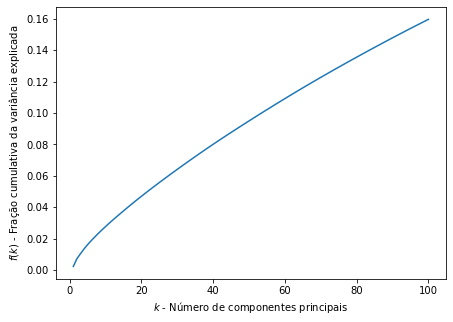

In [17]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

Aplicando o número máximo de componentes principais percebemos que talvez seja preciso um aumento no número de samples uma vez que o valor de componentes principais deve estar no intervalo entre
$$\left[0, \ min(n_{samples} \ , \ n_{features}) \right]$$

# Analise da Quantidade de Grupos

### Silhoutte score

Text(0, 0.5, 'Silhouette Score')

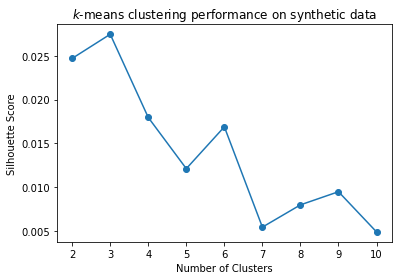

In [18]:
def sc_evaluate_clusters(X, max_clusters, n_init, seed):
    s = np.zeros(max_clusters+1)
    s[0] = 0
    s[1] = 0
    for k in range(2, max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters = k, n_init = n_init, random_state = seed)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X, kmeans.labels_, metric = 'euclidean')
    return s

s = sc_evaluate_clusters(freq_reduced, 10, 10, 1)
plt.plot(range(2, len(s)), s[2:], 'o-')
plt.xlabel('Number of Clusters')
plt.title('$k$-means clustering performance on synthetic data')
plt.ylabel('Silhouette Score')

### Dendogram

In [19]:
euclidian_dists = metrics.euclidean_distances(df_freq_reduced.values)
euclidian_dists.shape

(1600, 1600)

<ipython-input-20-f0899bcf4a1a>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  eucli_dists = hierarchy.linkage(euclidian_dists)


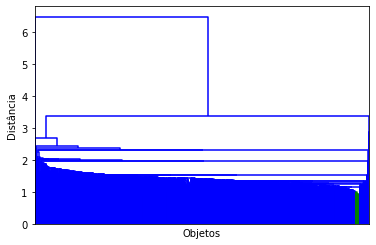

In [20]:
eucli_dists = hierarchy.linkage(euclidian_dists)
hierarchy.dendrogram(eucli_dists, color_threshold=1)
# plt.figure(facecolor='white')
plt.xticks([], [])
plt.ylabel('Distância')
plt.xlabel('Objetos')
plt.show()

### MDS

In [21]:
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2, max_iter=1000, eps=1e-9, random_state=0,
                   dissimilarity = "precomputed")
fit = mds.fit(euclidian_dists)
pos = fit.embedding_
plt.scatter(pos[:, 0], pos[:, 1], s=8)
plt.axis('square')

# K-means

In [ ]:
num_labels = df_mini['genre'].unique().size
print(num_labels)

8


In [ ]:
model = KMeans(n_clusters=2, random_state=42)
y_pred = model.fit_predict(df_freq_reduced)
# word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
# cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)

# Evaluate our model